In [57]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from itertools import combinations
import random
from sklearn.metrics import roc_auc_score, roc_curve
import editdistance
import numpy as np
import matplotlib.pyplot as plt

In [74]:
def label_pair(row):
    same_word = row["text1"] == row["text2"]
    same_speaker = row["speaker1"] == row["speaker2"]
    if same_word and same_speaker:
        return "C1"
    elif same_word and not same_speaker:
        return "C2"
    elif not same_word and same_speaker:
        return "C3"
    else:
        return "C4"


def create_samediff_dataset(align_df: pd.DataFrame):
    segments = []
    seen_speakers = set()
    align_df = align_df[align_df["text"].notna()]
    align_df = align_df.sample(n=500).reset_index(drop=True)
    for filename in tqdm(align_df["filename"].unique(), desc="Processing files"):
        speaker = filename.split("-")[0]
        if speaker not in seen_speakers:
            seen_speakers.add(speaker)
        file_df = align_df[align_df["filename"] == filename]

        for word_id in file_df["word_id"].unique():
            word_df = file_df[file_df["word_id"] == word_id]
            if len(word_df) == 0:
                continue
            base_filename = filename.split("_")[0]
            text = str(word_df["text"].values[0])
            if not text or text == "<unk>" or text == "nan":
                continue
            segment = {
                "filename": base_filename,
                "speaker": speaker,
                "text": text,
                "word_start": word_df["word_start"].values[0],
                "word_end": word_df["word_end"].values[0],
                "phones": word_df["phones"].values[0],
            }
            segments.append(segment)
    segment_df = pd.DataFrame(segments)

    min_instances = 5
    word_counts = segment_df["text"].value_counts()
    valid_words = word_counts[word_counts >= min_instances].index
    subset_df = segment_df[segment_df["text"].isin(valid_words)].reset_index(drop=True)

    max_pairs_per_word = 200
    max_word_instances = 5
    same_pairs = []
    for _, group in tqdm(
        subset_df.groupby("text"), desc="Creating same pairs", total=len(valid_words)
    ):
        group = group[:max_word_instances]  # Keep first 100 occurrences only

        items = group.to_dict("records")
        all_combos = list(combinations(items, 2))
        sampled_combos = random.sample(
            all_combos, min(len(all_combos), max_pairs_per_word)
        )

        for a, b in sampled_combos:
            label = 1
            pair_type = label_pair(
                pd.Series(
                    {
                        "text1": a["text"],
                        "text2": b["text"],
                        "speaker1": a["speaker"],
                        "speaker2": b["speaker"],
                    }
                )
            )
            same_pairs.append((a, b, label, pair_type))

    all_items = subset_df.to_dict("records")
    diff_pairs = []
    attempts = 0
    max_attempts = len(same_pairs) * 10

    while len(diff_pairs) < len(same_pairs) and attempts < max_attempts:
        a, b = random.sample(all_items, 2)
        if a["text"] != b["text"]:
            label = 0
            pair_type = label_pair(
                pd.Series(
                    {
                        "text1": a["text"],
                        "text2": b["text"],
                        "speaker1": a["speaker"],
                        "speaker2": b["speaker"],
                    }
                )
            )
            diff_pairs.append((a, b, label, pair_type))
        attempts += 1

    pair_records = []
    for a, b, label, pair_type in same_pairs + diff_pairs:
        pair_records.append(
            {
                "file1": a["filename"],
                "speaker1": a["speaker"],
                "text1": a["text"],
                "start1": a["word_start"],
                "end1": a["word_end"],
                "phones1": a["phones"],
                "file2": b["filename"],
                "speaker2": b["speaker"],
                "text2": b["text"],
                "start2": b["word_start"],
                "end2": b["word_end"],
                "phones2": b["phones"],
                "label": label,
                "pair_type": pair_type,
            }
        )

    pairs_df = pd.DataFrame(pair_records)

    return pairs_df


In [75]:
align_df = pd.read_csv(Path("librispeech/alignments/dev-clean/alignments.csv"))
pairs_df = create_samediff_dataset(align_df)

Creating same pairs: 100%|██████████| 15/15 [00:00<00:00, 786.26it/s]


In [76]:
def load_encodings(feat_dir: Path, align_df: pd.DataFrame, filenames_in_pairs_df: set):
    encodings = {}
    text = {}
    paths = list(feat_dir.glob("**/*.npy"))
    paths = [
        path
        for path in tqdm(paths, desc="Filtering files")
        if (
            path.stem.split("_")[0] in filenames_in_pairs_df
            and path.stem.split("_")[0] in align_df["filename"].values
        )
    ]

    for file in tqdm(paths, desc="Loading encodings"):
        filename = file.stem.split("_")[0]
        word_id = int(file.stem.split("_")[1])

        file_df = align_df[align_df["filename"] == filename]

        if word_id not in file_df["word_id"].values:
            print(f"⚠️ Word ID {word_id} not found in {filename}. Skipping.")
            continue

        word_df = file_df[file_df["word_id"] == word_id]
        start_time = word_df["word_start"].iloc[0]
        end_time = word_df["word_end"].iloc[0]

        key = (filename, float(start_time), float(end_time))
        encodings[key] = np.load(file)
        text[key] = str(word_df["text"].values[0])

    return encodings, text


def same_different_evaluation(
    pairs_df: pd.DataFrame, feat_dir: Path, align_df: pd.DataFrame
):
    filenames_in_pairs_df = set(pairs_df["file1"]).union(set(pairs_df["file2"]))
    word_encodings, text = load_encodings(feat_dir, align_df, filenames_in_pairs_df)

    skipped = 0
    labels = []
    scores = []

    for _, row in pairs_df.iterrows():
        key1 = (row["file1"], row["start1"], row["end1"])
        key2 = (row["file2"], row["start2"], row["end2"])
        seq1 = word_encodings.get(key1)
        seq2 = word_encodings.get(key2)

        if seq1 is None or len(seq1) == 0:
            skipped += 1
            continue
        if seq2 is None or len(seq2) == 0:
            skipped += 1
            continue

        d = editdistance.eval(seq1, seq2) / max(len(seq1), len(seq2))
        score = -d
        print(
            f"{text.get(key1)} [{seq1}] vs {text.get(key2)} [{seq2}]: {score:.3f} (label: {row['label']})"
        )

        labels.append(row["label"])
        scores.append(score)

    print(f"Skipped {skipped} pairs due to missing encodings.")

    if len(set(labels)) < 2:
        print("⚠️ Not enough positive/negative samples to compute ROC.")
        return

    auc = roc_auc_score(labels, scores)
    fpr, tpr, _ = roc_curve(labels, scores)

    # Plot once
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Same-Different ROC Curve")
    plt.grid()
    plt.legend()
    plt.tight_layout()


Loading encodings: 100%|██████████| 4387/4387 [00:15<00:00, 275.27it/s]


a [[44 19  0  3]] vs a [[27 47]]: -1.000 (label: 1)
a [[44 19  5 14]] vs a [[27 47]]: -1.000 (label: 1)
a [[ 9 47]] vs a [[44 19  0  3]]: -1.000 (label: 1)
a [[ 9 47]] vs a [[27 47]]: -0.500 (label: 1)
a [[44 19  0  3]] vs a [[44 19  5 14]]: -0.500 (label: 1)
a [[47 30]] vs a [[27 47]]: -1.000 (label: 1)
a [[ 9 47]] vs a [[47 30]]: -1.000 (label: 1)
a [[44 19  0  3]] vs a [[47 30]]: -1.000 (label: 1)
a [[44 19  5 14]] vs a [[47 30]]: -1.000 (label: 1)
a [[ 9 47]] vs a [[44 19  5 14]]: -1.000 (label: 1)
and [[27 34 38 31]] vs and [[27 34 38 15 18]]: -0.400 (label: 1)
and [[27 34 38 31]] vs and [[27 30 34 38 33]]: -0.400 (label: 1)
and [[27 34 38 31]] vs and [[44 19 30 34 38]]: -0.800 (label: 1)
and [[27 34 38 31]] vs and [[27 34 38 31]]: -0.000 (label: 1)
and [[27 34 38 31]] vs and [[27 34 38 15 18]]: -0.400 (label: 1)
and [[44 19 30 34 38]] vs and [[27 34 38 15 18]]: -1.000 (label: 1)
and [[27 30 34 38 33]] vs and [[44 19 30 34 38]]: -0.600 (label: 1)
and [[44 19 30 34 38]] vs and [[27

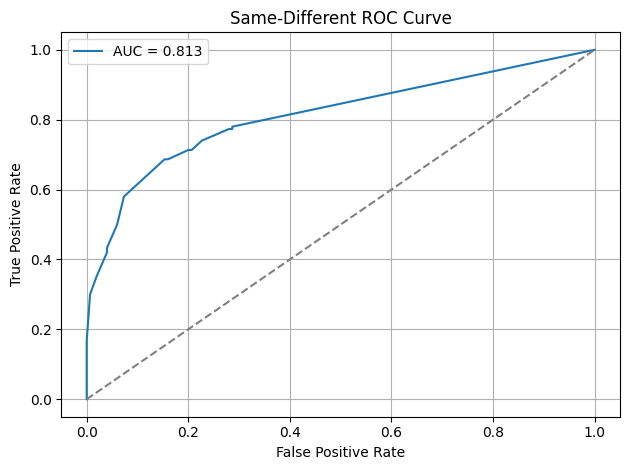

In [80]:
same_different_evaluation(
    pairs_df,
    Path("features/wavlm_large/layer11/gamma0.1/k50"),
    align_df,
)